# Cloud Classification using Random Forest

Generalized Random forest script for pixel-wise classification of very high-resolution rasters.

In this notebook you will be able to classify satellite imagery using random forest, particularly the cloud and cloud shadow masking. The imagery used in this notebook is in raster format, particularly TIF files. This notebook will leverage the xrasterlib library and software will be contained inside a conda environment. This can be executed using both GPU and/or CPU resources. 

## Table of Contents

1. Installation
2. Libraries
3. Define Parameters
4. Train
5. Classify

### Installation

The following notebook requires a Conda environment in order to be executed. Assuming you will be installing this environment in adapt, feel free to follow the instructions listed below.
```
git clone https://github.com/jordancaraballo/xrasterlib.git
conda create -n rapids-0.16 -c rapidsai -c nvidia -c conda-forge     -c defaults rapids=0.16 python=3.7 cudatoolkit=10.2
cd xrasterlib; conda create --name xrasterlib;
conda activate xrasterlib
conda install -c anaconda pip 
conda install -c anaconda cudatoolkit=10.1 cudnn # if GPU available
pip install --upgrade -r requirements/requirements.txt
python setup.py install
```

### Libraries
The libraries included below are loaded based in the availability of resources. The RAPIDS framework will be loaded only if GPU resources are available. If not, SckitLearn will be used to train and classify the imagery.

In [1]:
# Import utility libraries
import os  
import gc  
import sys
import pickle
import logging
import warnings
from time import time
from datetime import datetime

In [2]:
%load_ext autoreload

# Import data manipulation libraries
import numpy as np
import pandas as pd
from xrasterlib.rf import RF
import xrasterlib.indices as indices

# Fix numpy seed for reproducibility
seed = 21
np.random.seed(seed)

# Ignoring true_divide errors since we know they are expected
warnings.filterwarnings(
    "ignore", "invalid value encountered in true_divide", RuntimeWarning
)
warnings.filterwarnings(
    "ignore", "Some inputs do not have OOB scores. ", UserWarning
)

### Define Parameters
In order to execute these notebooks, a set of variables and files will need to be defined before moving on. In order to save time and resources, this notebook offers the option of trainining or classifying, or performing both. The variables found below will be used to perform these operations.

In [3]:
### Global Parameters
TRAIN = True  # specify if training a new model
CLASSIFY = True  # specify if classifying from existing model

### Train

The CSV file generated for training has the format of rows x bands, which implies that there
is a column per band, and each row represents a point in the raster. The last column of each
training CSV file includes a binary mask for determining if the point is cloud or cloud free. 
```
Example:
2306,2086,2005,1914,1916,2273,2959,2462,1043,-1897,-2147483648,1
2310,2097,2002,1921,1936,2288,2953,2484,1017,-1901,-2147483648,0
```
Wooten's team has concluded that the use of 3 additional indices improves the classification of 
cloud pixels. The indices calculated at his time are FDI, SI, and NDWI. The order of the bands that 
are being studied in this project depend on the number of bands included in the rasters. 
```
8 band imagery - ['CoastalBlue', 'Blue', 'Green', 'Yellow', 'Red', 'RedEdge','NIR1', 'NIR2']
4 band imagery - ['Blue', 'Green', 'Red', 'NIR1'] or ['Red', 'Green', 'Blue', 'NIR1']
```

#### Training Data

A couple of files have been located in ADAPT to ease finding data for training. The files with
their description are listed below, the path is /att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/training.
This data might be moved to /att/pubrepo/ILAB/projects/Vietnam/cloudmask_data at some point.

| Filename                                  | Description     | 
| :---------------------------------------- |:----------------|
| cloud_training.csv                        | training data using all 8 bands from imagery and the 3 indices calculated using all of the bands (FDI, SI, DVI). | 
| cloud_training_8band_fdi_si_ndwi.csv      | training data using all 8 bands from imagery and the 3 indices calculated using all of the bands.  | 
| cloud_training_4band_fdi_si_ndwi.csv      | training data using only 4 bands from imagery and the 3 indices calculated using only 4 bands. The order of the bands goes accordingly to 8 band imagery (B-G-R-NIR).  |
| cloud_training_4band_rgb_fdi_si_ndwi.csv  | training data using only 4 bands from imagery and the 3 indices calculated using only 4 bands. The order of the bands was fixed to match (R-G-B-NIR).  |

In [4]:
# Define parameters
train_csv = "/att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/training/cloud_training.csv"  # training csv
out_dir = "/att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/models"  # output directory to save model and logs
model_file = "model_20_log2_8band_fdi_si_dvi.pkl"  # model filename (.pkl)
n_trees = 20  # number of trees to initialize RF
max_feat = "log2"  # number of max features
test_size = 0.30  # percentage of data for test dataset

In [5]:
%%time

# Create output directory
os.system(f'mkdir -p {out_dir}')

if TRAIN:

    # Instantiate RandomForest object
    raster_obj = RF(
        traincsvfile=train_csv, modelfile=model_file,
        outdir=out_dir, ntrees=n_trees, maxfeat=max_feat
    )
    
    print('Initializing RF script with the following parameters')
    print(f'Working Directory: {out_dir}')
    print(f'ntrees:            {n_trees}')
    print(f'max features:      {max_feat}')
    print(f'model filename:    {model_file}')
    raster_obj.splitdata(testsize=test_size, seed=seed)  # read, split
    raster_obj.train()  # train and save RF model

Initializing RF script with the following parameters
Working Directory: /att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/models
ntrees:            20
max features:      log2
model filename:    model_20_log2_8band_fdi_si_dvi.pkl
Train data includes 2 classes.
X matrix is sized: (700000, 11)
Y array is sized:  (700000,)
Training with ntrees=20 and maxfeat=log2
Training model via RAPIDS.
Training accuracy: 0.99862
CPU times: user 3.73 s, sys: 2.37 s, total: 6.1 s
Wall time: 1min 52s


## Classify

Once the models have been trained, is time to classify the rasters. The imagery for this work is located in the following paths. For 8 band imagery we can use 8 band models or 4 band models after dropping the unnecessary bands. In this case, we will use the 8 band model for 8 band imagery, and 4 band model for 4 band imagery. This can be discussed further in a later discussion.

| Description                                  | Location     | 
| :---------------------------------------- |:----------------|
| 8-band MS @ 2 m resolution                | /att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/8-band | 
| 8-band MS pansharpened to 0.5 m resolution| /att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/8-band/pansharpen | 
| 4-band MS @ 2 m resolution                | /att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS |
| 4-band MS pansharpened to 0.5 m resolution| /att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/pansharpen |

In [6]:
# Define Parameters
model_file = "/att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/models/model_20_log2_8band_fdi_si_dvi.pkl"
out_dir = "/att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/classification/model_20_log2_8band_fdi_si_dvi"

In [7]:
# Create output directory
os.system(f'mkdir -p {out_dir}')

# Initialize RF object
raster_obj = RF(modelfile=model_file, outdir=out_dir)

# Load RF model to CPU or GPU, reads model from file
raster_obj.load()

Loaded model /att/gpfsfs/briskfs01/ppl/jacaraba/cloudmask_data/models/model_20_log2_8band_fdi_si_dvi.pkl.


In [8]:
# Specfy rasters to classify
rasters = [
    '/att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/8-band/WV02_20140716_M1BS_103001003328DB00-toa.tif',
    #'/att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/8-band/WV02_20140810_M1BS_103001003526DB00-toa.tif'
]
bands = ['CoastalBlue', 'Blue', 'Green', 'Yellow', 'Red', 'RedEdge', 'NIR1', 'NIR2']

Loading /att/gpfsfs/briskfs01/ppl/mwooten3/Vietnam_LCLUC/TOA/M1BS/8-band/WV02_20140716_M1BS_103001003328DB00-toa.tif


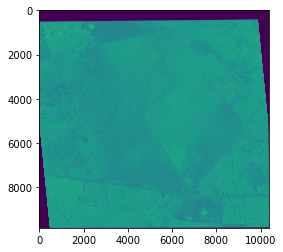

CPU times: user 9.95 s, sys: 3.23 s, total: 13.2 s
Wall time: 19.8 s


In [19]:
%%time
%matplotlib inline
from matplotlib import pyplot
    
# Plot imagery
rast = rasters[0]
print(f'Loading {rast}')
raster_obj.readraster(rast, bands)  # read raster
pyplot.imshow(raster_obj.data[6,:], cmap='viridis')
pyplot.show()

# remove anomalous pixels, make boundaries (0, 10000)
# this process should be taken care in the data preparation process, 
# but we are working with it for now in the meantime
raster_obj.preprocess(op='>', boundary=0, subs=0)
raster_obj.preprocess(op='<', boundary=10000, subs=10000)

# add additional indices that are missing at this time
raster_obj.addindices(
    [indices.fdi, indices.si, indices.ndwi], factor=10000.0
)
   
# Convert to row format
# Predict    
    